Independent component analysis separates a multivariate signal into additive subcomponents that are maximally independent. It is implemented in scikit-learn using the Fast ICA algorithm. Typically, ICA is not used for reducing dimensionality but for separating superimposed signals. Since the ICA model does not include a noise term, for the model to be correct, whitening must be applied. This can be done internally using the whiten argument or manually using one of the PCA variants.

more [here](https://scikit-learn.org/stable/modules/decomposition.html#ica)

FastICA: a fast algorithm for Independent Component Analysis.

The implementation is based on

[sklearn.decomposition.FastICA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html#sklearn.decomposition.FastICA)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_normal = pd.read_csv('./data/normal_training.csv')

In [3]:
# train_normal.head()

In [4]:
test_faulty = pd.read_csv('./data/faulty_testing.csv')

In [5]:
# test_faulty.head()

In [6]:
import numpy as np
import sklearn.decomposition
import sklearn.preprocessing

## Preparing the data

In [7]:
df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]

In [8]:
df_validation = train_normal[(train_normal.simulationRun>1)&(train_normal.simulationRun<5)].iloc[:,3:]

In [9]:
df_test = train_normal[(train_normal.simulationRun>5)&(train_normal.simulationRun<10)].iloc[:,3:]

# Model FastICA

In [10]:
class ModelFastICA:

    # spe: squared prediction errors
    def spe (self, X, X_pred): 
        return np.sum((X-X_pred)**2, axis=1)
   
    def train(self, df_train, n_components=0):
        
        self.mu_train = df_train.mean(axis=0)
        self.std_train = df_train.std(axis=0)
        
        # Simply set n_components to be float, and it will be used as a 
        # lower bound of explained variance.
        
        self.m = sklearn.decomposition.FastICA()
        
        X_train = sklearn.preprocessing.scale(df_train)
        # Transform data back to its original space.
        X_train_pred = self.m.inverse_transform(self.m.fit_transform(X_train)) 
        
        return self.spe(X_train, X_train_pred) # return spe
            
    def test(self, df_test):
        
        # standardizing test data according to the mu and std of training set
        X_test = np.array((df_test-self.mu_train)/self.std_train) 
        X_test_pred = self.m.inverse_transform(self.m.transform(X_test))

        return self.spe(X_test, X_test_pred)

# Training Data

In [11]:
models = {'FastICA': ModelFastICA()}
detection_limits = {}

for name, model in models.items():
    
    spe_train = model.train(df_train)
    spe_validation = model.test(df_validation)
    spe_test = model.test(df_test)
    
    detection_limits[name] = np.percentile(spe_validation, 99.99)
    

c:\users\m477a\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


In [12]:
detection_limits

{'FastICA': 2.6019482254527785e-23}

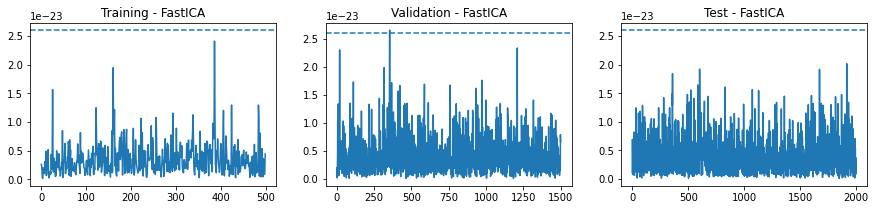

In [13]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.plot(spe_train)
plt.title(f'Training - FastICA')
plt.axhline(detection_limits['FastICA'], ls = '--')

plt.subplot(1,3,2)
plt.plot(spe_validation)
plt.title(f'Validation - FastICA')
plt.axhline(detection_limits['FastICA'], ls = '--')

plt.subplot(1,3,3)
plt.plot(spe_test)
plt.title(f'Test - FastICA')
plt.axhline(detection_limits['FastICA'], ls = '--')

# Testing Data

FastICA    21.06875
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
FastICA,98.25,0.75,0.0,0.125,3.0,99.875,12.375,42.0,0.0,0.0,0.0,53.5,30.25,0.125,0.0,0.0,0.0,81.125,0.0,0.0


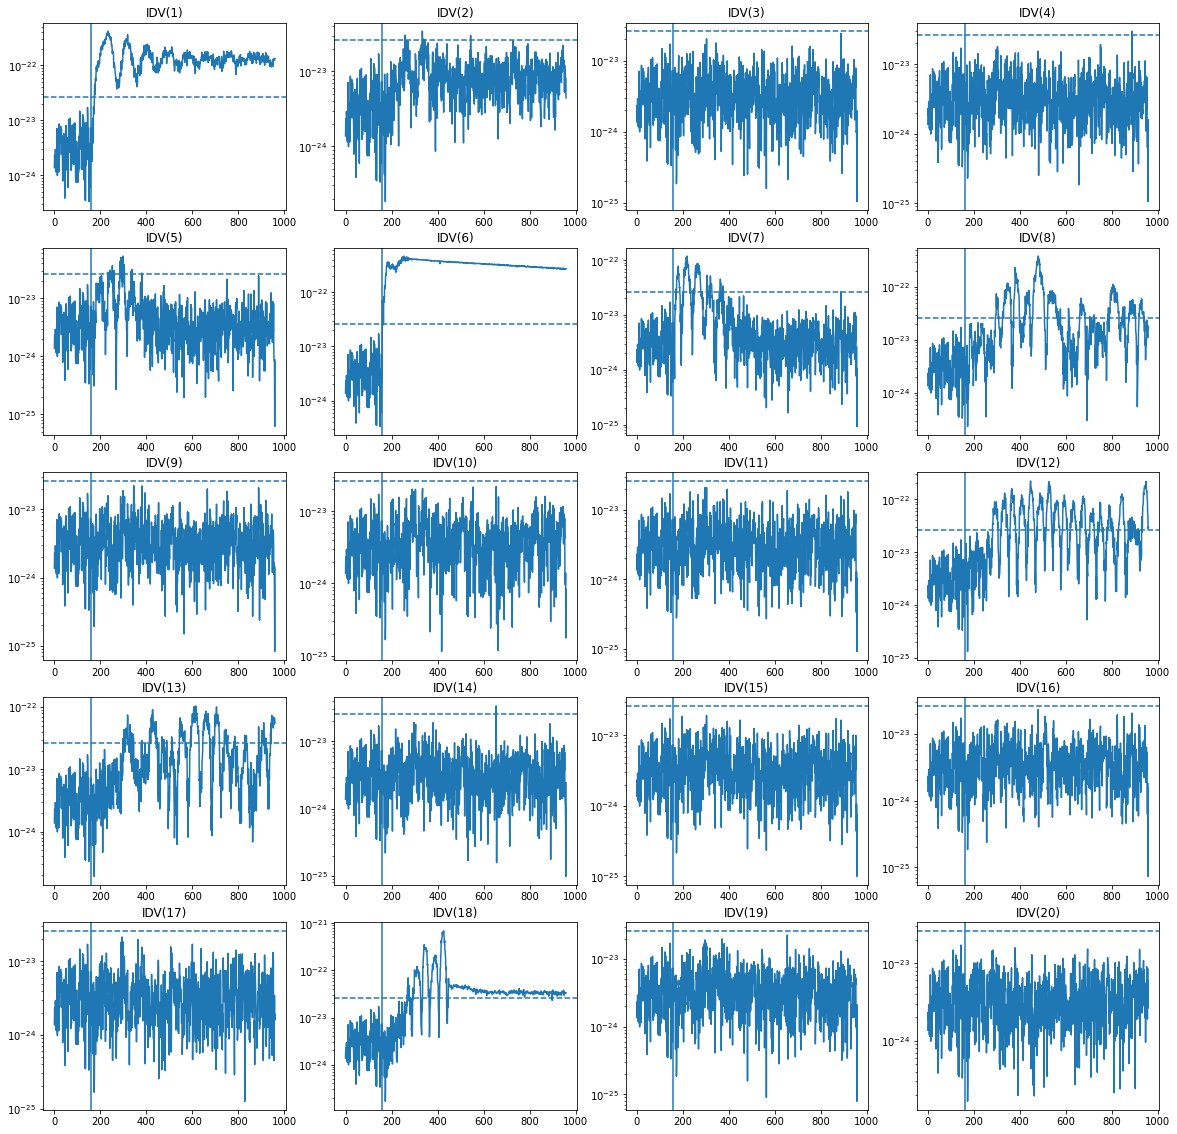

In [14]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []

    for i in range(20):

        df_test = test_faulty[(test_faulty.faultNumber==i+1) & (test_faulty.simulationRun==1)].iloc[:,3:]

        spe_test.append(model.test(df_test))

        fault_occurrence = len(spe_test[i])//6

        fdr.append(np.mean(spe_test[i][fault_occurrence:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(np.arange(len(spe_test[i])), spe_test[i], color = color)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean()) # average of the detection error for every type of disturbance   
100*fdr_df.T

In [15]:
# spe_test

In [25]:
# the Question :
# 1. if i want to detect the fault detection why 
#    we cannot use the train faulty as training data and test faulty as test data
#    instead we using train normal as training data and test faulty as test data ???

# 2. I think i need more careful with the data

# Model FastICA30

In [26]:
class ModelFastICA30:
    
    # spe: squared prediction errors
    def spe (self, X, X_pred): 
        return np.sum((X-X_pred)**2, axis=1)
   
    def train(self, df_train, n_components=0):
        
        self.mu_train = df_train.mean(axis=0)
        self.std_train = df_train.std(axis=0)
        
        # Simply set n_components to be float, and it will be used as a 
        # lower bound of explained variance.

        self.m = sklearn.decomposition.FastICA(n_components=30) 
            
        X_train = sklearn.preprocessing.scale(df_train)
        # Transform data back to its original space.
        X_train_pred = self.m.inverse_transform(self.m.fit_transform(X_train)) 
        
        return self.spe(X_train, X_train_pred) # return spe
            
    def test(self, df_test):
        
        # standardizing test data according to the mu and std of training set
        X_test = np.array((df_test-self.mu_train)/self.std_train) 
        X_test_pred = self.m.inverse_transform(self.m.transform(X_test))

        return self.spe(X_test, X_test_pred)

**if we change the n_components of the model**
# Training with 30 n_components

In [27]:
models = {'FastICA30': ModelFastICA30()}
detection_limits = {}

for name, model in models.items():
    
    spe_train = model.train(df_train)
    spe_validation = model.test(df_validation)
    spe_test = model.test(df_test)
    
    detection_limits[name] = np.percentile(spe_validation, 99.99)

c:\users\m477a\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


In [28]:
detection_limits
# the detection limit from n_component 52 with n_component 30
# are different the 52 around 2.8e-23 and the 30 around 25.4

{'FastICA30': 25.445661093931736}

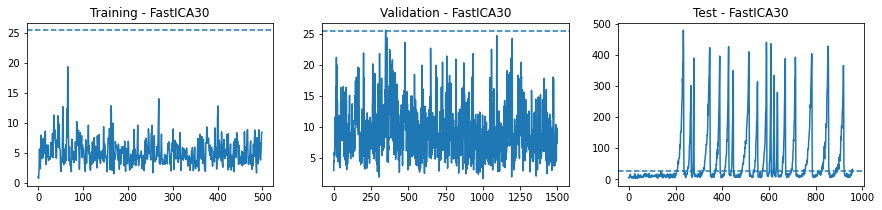

In [29]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.plot(spe_train)
plt.title(f'Training - FastICA30')
plt.axhline(detection_limits['FastICA30'], ls = '--')

plt.subplot(1,3,2)
plt.plot(spe_validation)
plt.title(f'Validation - FastICA30')
plt.axhline(detection_limits['FastICA30'], ls = '--')

plt.subplot(1,3,3)
plt.plot(spe_test)
plt.title(f'Test - FastICA30')
plt.axhline(detection_limits['FastICA30'], ls = '--')

# Testing the new model with 30 components only

FastICA30    58.99375
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
FastICA30,99.625,98.0,0.75,87.25,15.625,100.0,99.25,96.75,0.75,12.25,37.375,96.375,90.5,99.875,0.875,22.625,81.625,92.5,2.625,45.25


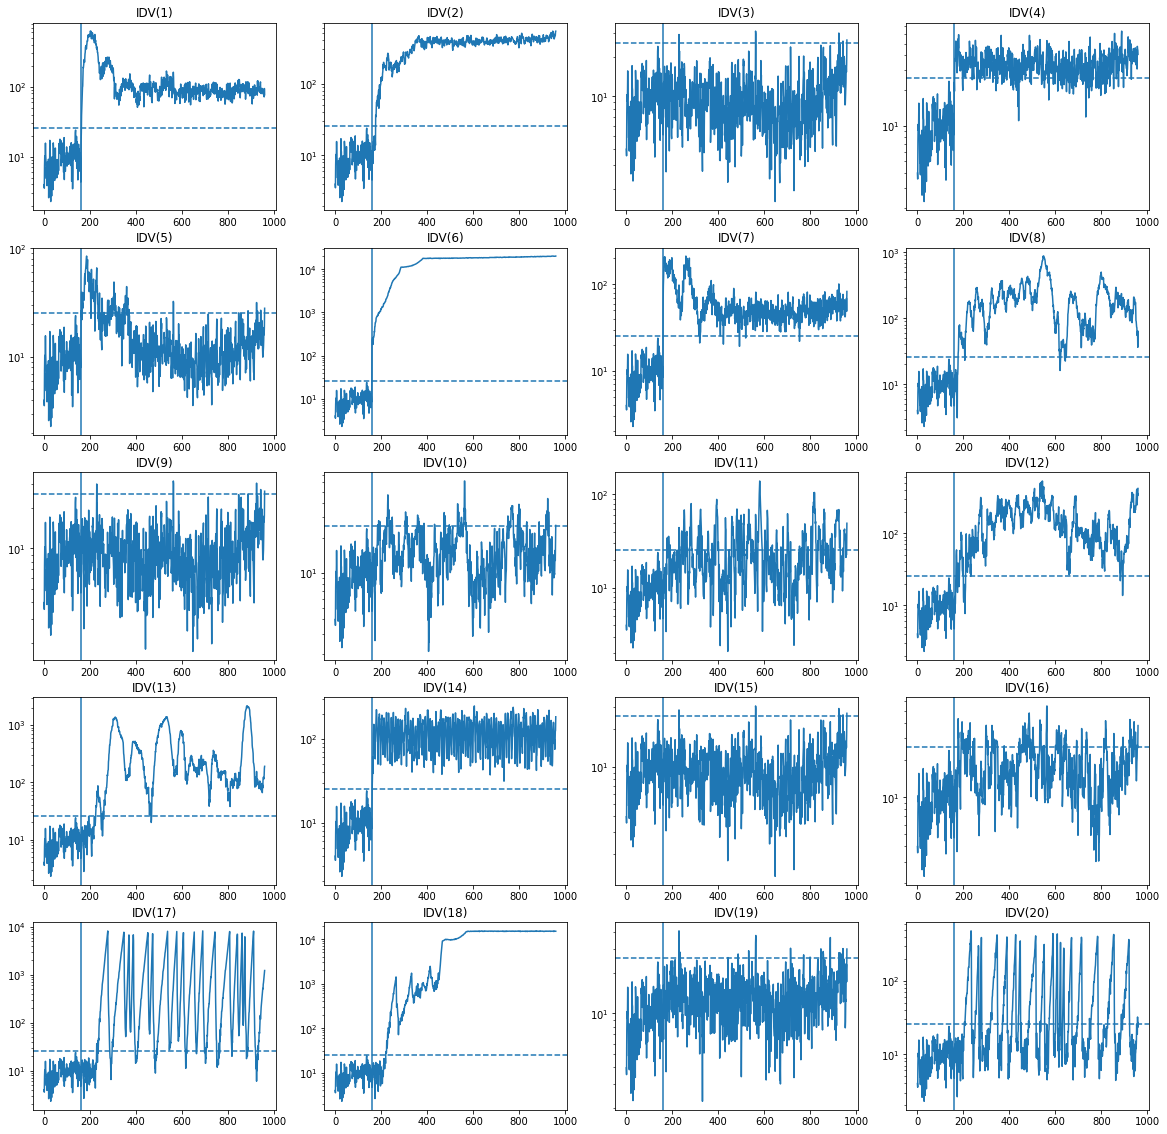

In [30]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []

    for i in range(20):

        df_test = test_faulty[(test_faulty.faultNumber==i+1) & (test_faulty.simulationRun==1)].iloc[:,3:]

        spe_test.append(model.test(df_test))

        fault_occurrence = len(spe_test[i])//6

        fdr.append(np.mean(spe_test[i][fault_occurrence:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(np.arange(len(spe_test[i])), spe_test[i], color = color)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean()) # average of the detection error for every type of disturbance   
100*fdr_df.T

In [31]:
# fdr_df.to_csv('./experimental_result_csv/fastica30.csv')

# Combine

In [32]:
class ModelFastICA2:
    
    def __init__(self, n_components):
        self.n_components=n_components

    # spe: squared prediction errors
    def spe (self, X, X_pred): 
        return np.sum((X-X_pred)**2, axis=1)
   
    def train(self, df_train, n_components=0):
        
        self.mu_train = df_train.mean(axis=0)
        self.std_train = df_train.std(axis=0)
        
        # Simply set n_components to be float, and it will be used as a 
        # lower bound of explained variance.
        
        if self.n_components == 0:
            self.m = sklearn.decomposition.FastICA()
        else:
            self.m = sklearn.decomposition.FastICA(n_components=self.n_components)
            
        X_train = sklearn.preprocessing.scale(df_train)
        # Transform data back to its original space.
        X_train_pred = self.m.inverse_transform(self.m.fit_transform(X_train)) 
        
        return self.spe(X_train, X_train_pred) # return spe
            
    def test(self, df_test):
        
        # standardizing test data according to the mu and std of training set
        X_test = np.array((df_test-self.mu_train)/self.std_train) 
        X_test_pred = self.m.inverse_transform(self.m.transform(X_test))

        return self.spe(X_test, X_test_pred)

# Training the data and models

In [33]:
models = {'FastICA': ModelFastICA2(0), 'FastICA30':ModelFastICA2(30)}
detection_limits = {}

for name, model in models.items():
    
    spe_train = model.train(df_train)
    spe_validation = model.test(df_validation)
    spe_test = model.test(df_test)
    
    detection_limits[name] = np.percentile(spe_validation, 99.99)

c:\users\m477a\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
c:\users\m477a\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


# Testing the Models

FastICA      23.00625
FastICA30    58.99375
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
FastICA,98.750,0.625,0.00,0.00,7.000,100.0,15.625,61.125,0.00,0.50,0.000,61.125,31.75,0.000,0.000,0.250,0.000,83.25,0.000,0.125
FastICA30,99.625,98.000,0.75,87.25,15.625,100.0,99.250,96.750,0.75,12.25,37.375,96.375,90.50,99.875,0.875,22.625,81.625,92.50,2.625,45.250


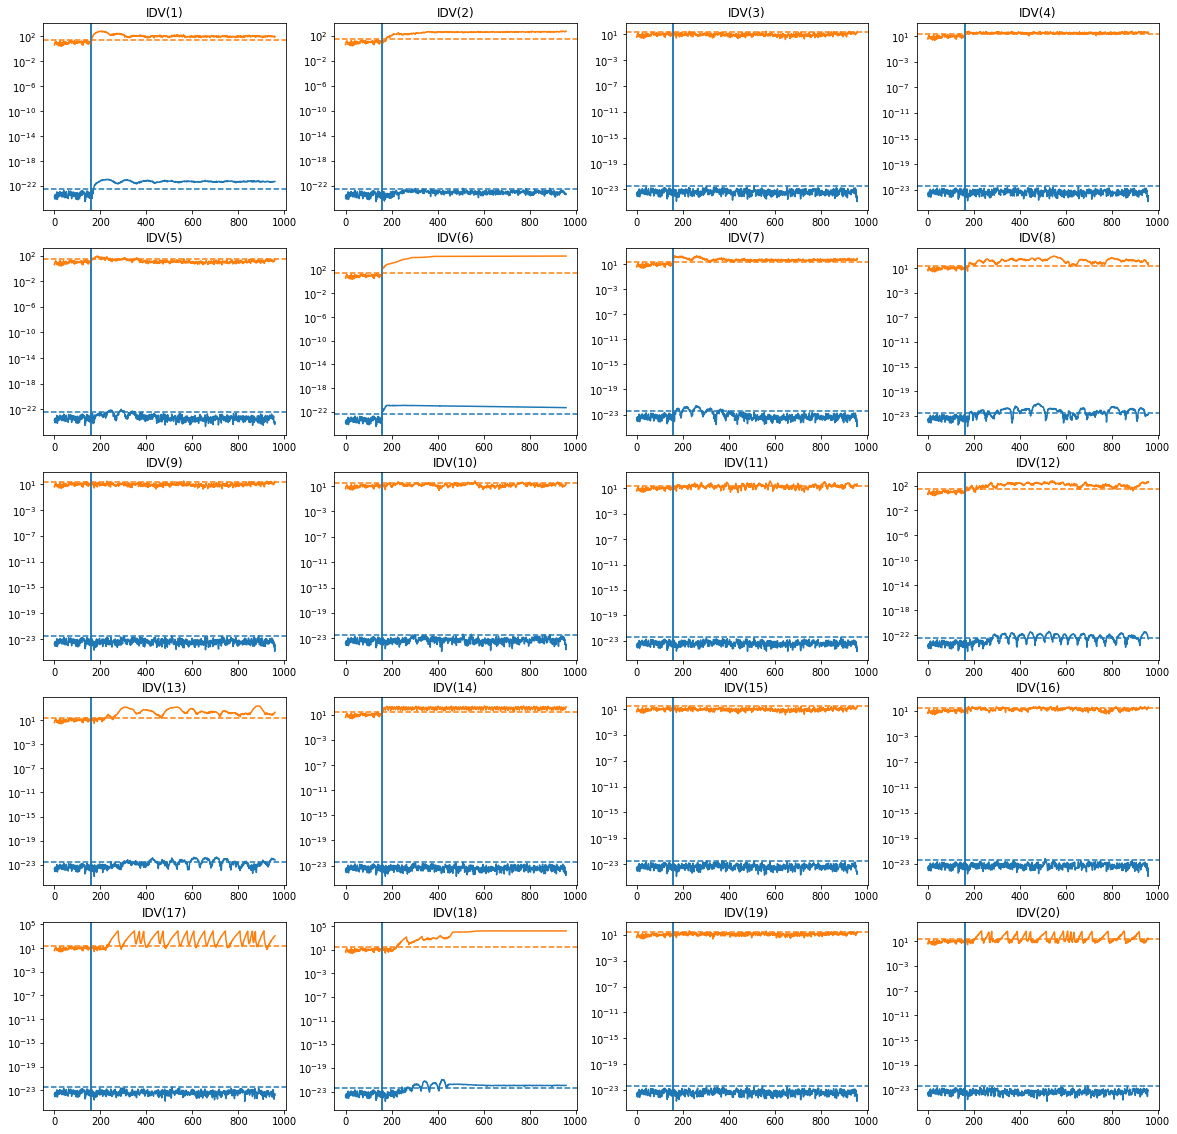

In [34]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []

    for i in range(20):

        df_test = test_faulty[(test_faulty.faultNumber==i+1) & (test_faulty.simulationRun==1)].iloc[:,3:]

        spe_test.append(model.test(df_test))

        fault_occurrence = len(spe_test[i])//6

        fdr.append(np.mean(spe_test[i][fault_occurrence:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(np.arange(len(spe_test[i])), spe_test[i], color = color)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean()) # average of the detection error for every type of disturbance    
100*fdr_df.T

In [35]:
# fdr_df

In [36]:
# fdr_df.mean()

## Lag variables

In [37]:
def apply_lag (df, lag = 1):
       
    from statsmodels.tsa.tsatools import lagmat
    array_lagged = lagmat(df, maxlag=lag,
                          trim="forward", original='in')[lag:,:]  
    new_columns = []
    for l in range(lag):
        new_columns.append(df.columns+'_lag'+str(l+1))
    columns_lagged = df.columns.append(new_columns)
    index_lagged = df.index[lag:]
    df_lagged = pd.DataFrame(array_lagged, index=index_lagged,
                             columns=columns_lagged)
       
    return df_lagged  

## Noise filtering

In [38]:
def filter_noise_ma (df, WS = 100,reduction = False):

    import copy
    
    new_df = copy.deepcopy(df)

    for column in df:
        new_df[column] = new_df[column].rolling(WS).mean()

    if reduction:
        return new_df.drop(df.index[:WS])[::WS]
    else:
        return new_df.drop(df.index[:WS])

## Adding lag variables

In [39]:
import scipy.stats

c:\users\m477a\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
c:\users\m477a\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
c:\users\m477a\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


fastICA_lag1    59.756250
fastICA_lag2    61.051314
fastICA_lag3    63.020050
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
fastICA_lag1,99.500000,98.000000,0.25,99.875,13.000000,100.0,100.0,97.750000,0.25,5.875000,59.375000,97.375000,90.500000,100.0,0.125,12.000000,81.750000,92.125000,3.000000,44.375000
fastICA_lag2,99.624531,98.122653,0.00,100.000,16.645807,100.0,100.0,97.872340,0.00,8.510638,66.332916,98.372966,91.239049,100.0,0.000,14.267835,82.978723,92.615770,8.760951,45.682103
fastICA_lag3,99.749373,98.621554,0.00,100.000,21.303258,100.0,100.0,97.994987,0.00,13.032581,73.433584,98.746867,92.982456,100.0,0.000,21.804511,84.962406,92.982456,15.664160,49.122807


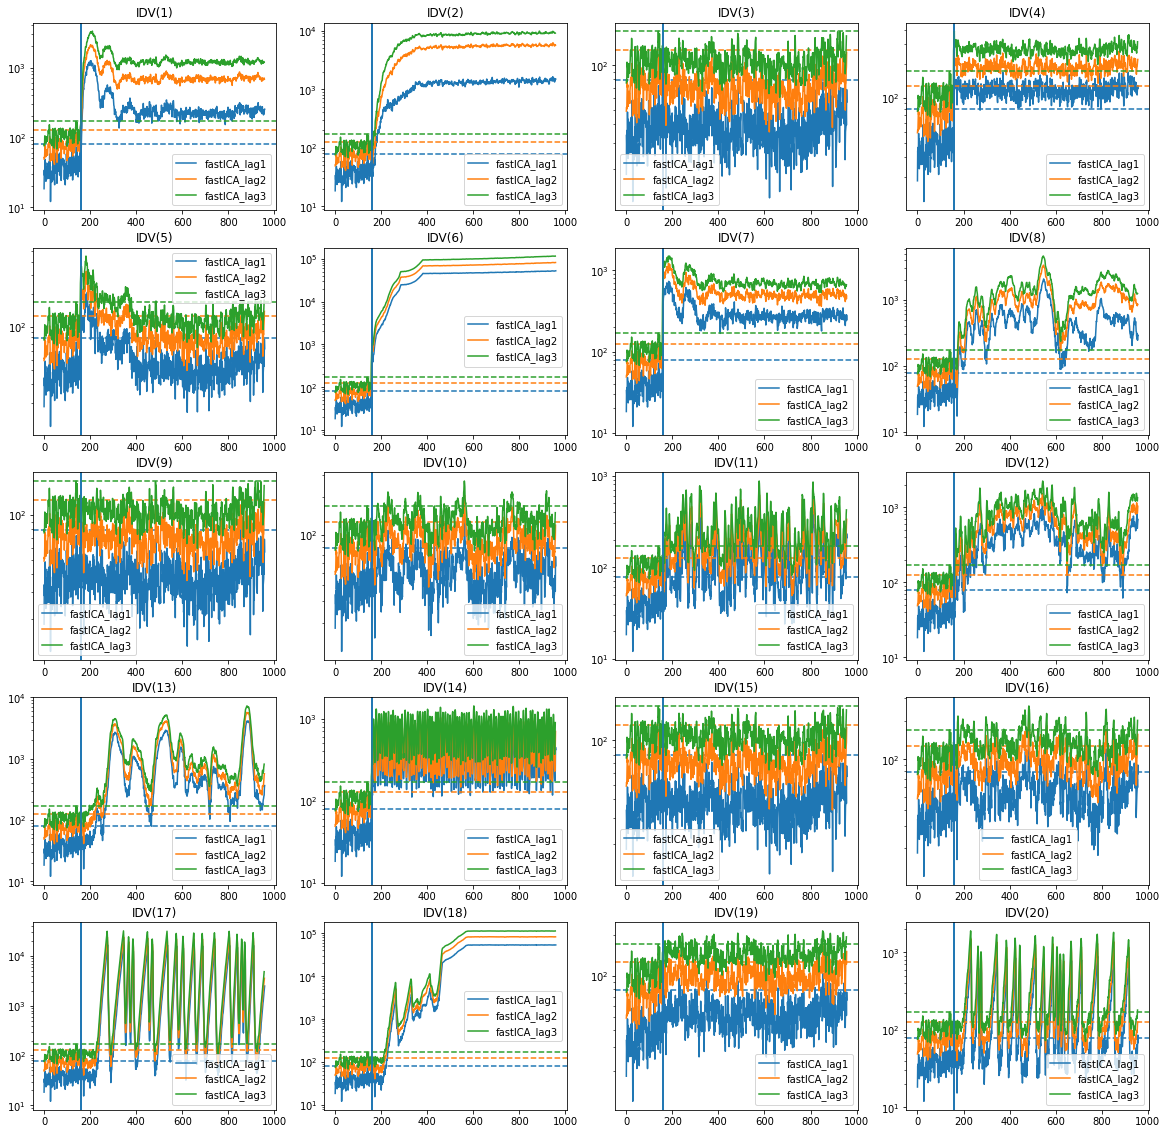

In [40]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]
df_validation = train_normal[(train_normal.simulationRun>1)&(train_normal.simulationRun<5)].iloc[:,3:]

models = {'fastICA_lag1': ModelFastICA2(30), 'fastICA_lag2': ModelFastICA2(30), 'fastICA_lag3': ModelFastICA2(30)}
lags = {'fastICA_lag1': 1, 'fastICA_lag2': 2, 'fastICA_lag3': 3}

detection_limits = {}

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []
    
    _ = model.train(apply_lag(df_train,lags[name]))
    spe_validation = model.test(apply_lag(df_validation,lags[name]))
    detection_limits[name] = np.percentile(spe_validation, 99.99)

    for i in range(20):
        
        df_test = apply_lag(test_faulty[(test_faulty.faultNumber==i+1) & 
                                        (test_faulty.simulationRun==1)].iloc[:,3:], lags[name])

        spe_test.append(model.test(df_test))

        fault_occurrence = len(spe_test[i])//6

        fdr.append(np.mean(spe_test[i][fault_occurrence:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(np.arange(len(spe_test[i])), spe_test[i], color = color, label=name)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        ax.ravel()[i].legend()
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean())
100*fdr_df.T

In [41]:
# fdr_df.to_csv('./experimental_result_csv/fasticalag.csv')

## Filter noise

WS_10     66.22500
WS_50     61.40000
WS_100    57.79375
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
WS_10,99.250,98.125,0.625,99.625,99.5,99.875,99.875,97.625,1.000,25.625,79.875,98.625,93.625,47.500,0.75,31.250,91.000,93.125,1.125,66.500
WS_50,98.625,97.125,0.125,98.500,99.0,99.500,99.375,96.750,0.250,16.000,55.875,89.375,92.000,1.625,0.00,8.000,90.375,91.875,0.500,93.125
WS_100,98.250,96.250,3.125,95.750,98.5,99.375,98.750,91.125,3.125,6.250,11.500,86.500,89.875,0.500,0.00,1.125,90.000,91.125,2.375,92.375


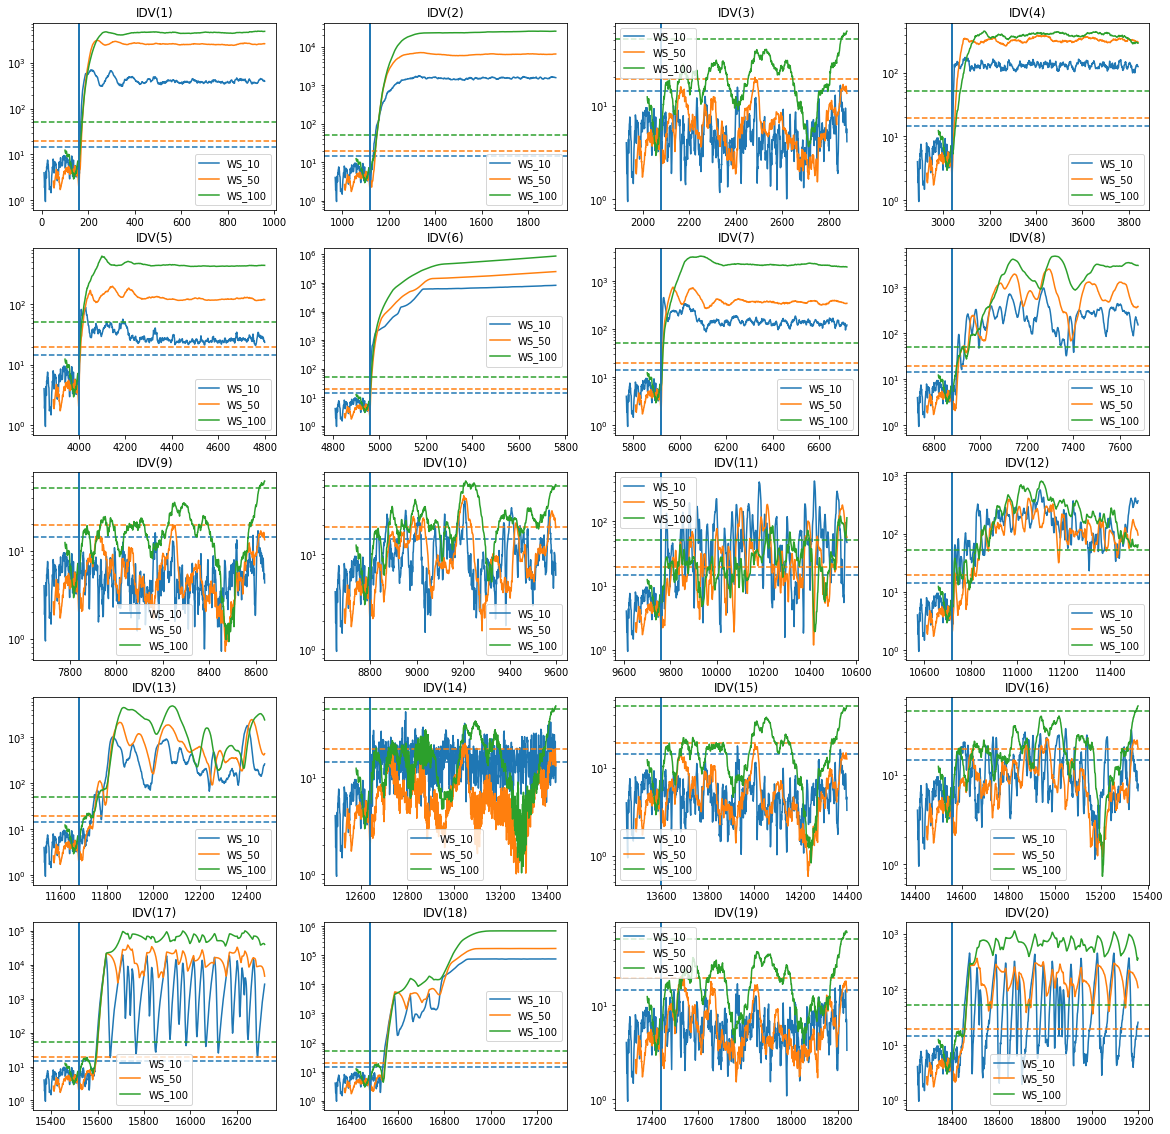

In [42]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]
df_validation = train_normal[(train_normal.simulationRun>1)&(train_normal.simulationRun<5)].iloc[:,3:]

models = {'WS_10': ModelFastICA2(30), 'WS_50': ModelFastICA2(30), 'WS_100': ModelFastICA2(30)}
WS = {'WS_10': 10, 'WS_50': 50, 'WS_100': 100}

detection_limits = {}

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []
    
    _ = model.train(filter_noise_ma(df_train,WS[name]))
    spe_validation = model.test(filter_noise_ma(df_validation, WS[name]))
    detection_limits[name] = np.percentile(spe_validation, 99.99)

    for i in range(20):
        
        df_test = filter_noise_ma(test_faulty[(test_faulty.faultNumber==i+1) & 
                                                 (test_faulty.simulationRun==1)].iloc[:,3:], WS[name])

        spe_test.append(model.test(df_test))

        fault_occurrence = df_test.index[0]-WS[name]+160

        fdr.append(np.mean(spe_test[i][160-WS[name]:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(df_test.index, spe_test[i], color = color, label=name)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)#, color = color)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        ax.ravel()[i].legend()
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean())
100*fdr_df.T

In [43]:
# fdr_df.to_csv('./experimental_result_csv/fasticanf.csv')

In [44]:
# fdr_df

In [45]:
# pip install statsmodels